In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import imageio
%load_ext autoreload
%autoreload 2
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *
import csv

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
vqae.load_state_dict(torch.load("best_checkpoint/residential/200-vqae-0.12810542326018284.pt"))

<All keys matched successfully>

In [3]:
#Load Dataset
floor = FloorPlanDataset(root='data/floorplan_crop/',subset='data/res_index.xlsx', multi_scale=False, preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=218, shuffle=False)

In [4]:
vqae.eval()
latents = None
with torch.no_grad():
    for data in data_loader:
        data = data.to(device)
        embedding_loss, quantized, perplexity, _ = vqae.latent(data)
        if latents is not None:
            latents = torch.cat([latents,quantized],dim=0)
        else: 
            latents = quantized

In [5]:
latents.shape

torch.Size([2138, 64, 14, 14])

In [6]:
torch.flatten(latents, start_dim=1).shape

torch.Size([2138, 12544])

# Embedding Space Visualization

In [7]:
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize the latent

D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


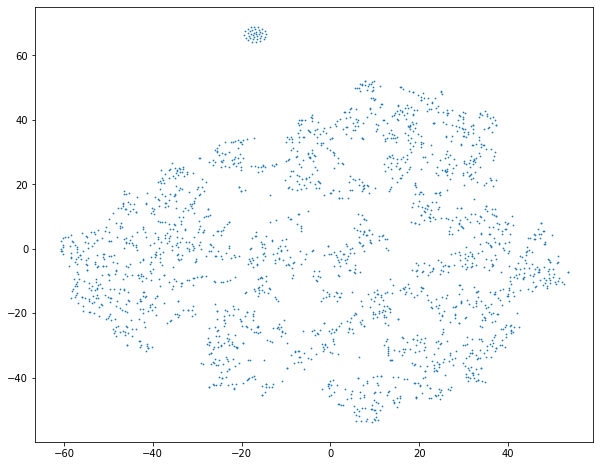

In [8]:
# create tsne object which will reduce data to 2 dimensions
plt.figure(figsize=(10, 8))

tsne = TSNE(n_components=2)
# apply t-SNE to data
data_2d = tsne.fit_transform(torch.flatten(latents, start_dim=1).cpu())
plt.scatter(data_2d[:,0], data_2d[:,1],s=0.5)

# visualise again and highlight actual classes of data

# colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']

# for i in range(10):
#     plt.scatter(data_2d[labels.cpu() == i, 0], data_2d[labels.cpu() == i, 1], c=colours[i])
#     pass

# plt.legend()
plt.show()

### Clustering

In [9]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 16)
 
#predict the labels of clusters.
label = kmeans.fit_predict(torch.flatten(latents, start_dim=1).cpu())
 
print(label)

[ 3 13 15 ... 15  8 15]


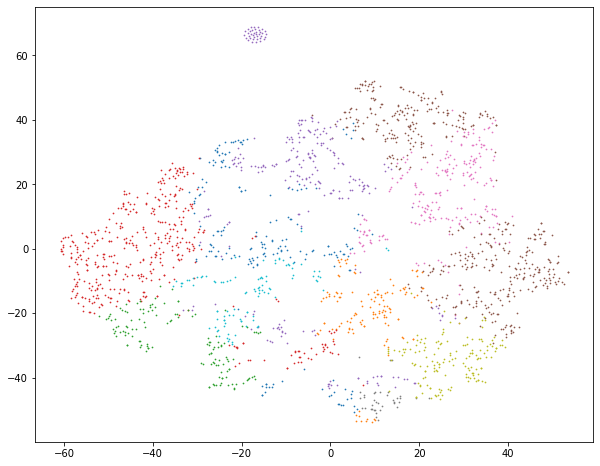

In [10]:
#Getting unique labels
plt.figure(figsize=(10, 8))

u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label = i, s=0.5)
# plt.legend()
plt.show()

### Recon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


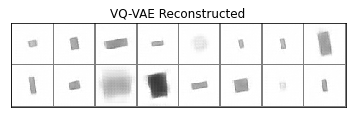

In [11]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(16, 64, 14, 14).astype('float32')).to(device)

vqae.eval()

valid_recon = vqae.decoder(latent_centers)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)

show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.savefig("VQrecon.png")

## For rhino mapping-back 

In [17]:
import glob
import cv2

In [13]:
valid_recon.shape

torch.Size([16, 1, 56, 56])

In [14]:
def show_and_save(img, filename):
    npimg = img.numpy()
    
    # get average pixel value that is not white
    # Get the average pixel value in the central 20x20 region
    npimg = img.numpy().squeeze()  # Remove the singleton dimensions
    # Get the dimensions of the image
    _, height, width = npimg.shape
    
    # Calculate the starting and ending indices for the central region
    start = (height - central_region_size) // 2
    end = start + central_region_size
    
    # Get the average pixel value in the central region for each channel
    central_region = npimg[:, start:end, start:end]
    average_pixel_value = np.mean(central_region, axis=(1, 2))
    
    # Draw a rectangle around the central region
    img_with_rectangle = np.copy(npimg)
    # img_with_rectangle[:, start:end, start:start+1] = 0  # Draw left vertical line
    # img_with_rectangle[:, start:end, end-1:end] = 0  # Draw right vertical line
    # img_with_rectangle[:, start:start+1, start:end] = 0  # Draw top horizontal line
    # img_with_rectangle[:, end-1:end, start:end] = 0 #  Draw bottom horizontal line
    
    # Resize image with rectangle to (224, 224)
    img_with_rectangle_resized = TF.resize(TF.to_pil_image(img_with_rectangle[0]), (224, 224))
    img_array = np.array(img_with_rectangle_resized)
    imageio.imwrite(filename, img_array)
    # title = str(average_pixel_value)
    # plt.imshow(np.transpose(img_with_rectangle, (1, 2, 0)), interpolation='nearest')
    # plt.axis('off')
    # #plt.title(title)
    # plt.savefig(filename, bbox_inches='tight')
    # plt.close()
    return average_pixel_value

central_region_size = 8
height_info = []
for i in range(valid_recon.shape[0]):
    reconstructed_img = valid_recon[i, 0, :, :]
    reconstructed_img_grid = torchvision.utils.make_grid(reconstructed_img.unsqueeze(0).cpu().data) + 0.5
    filename = f"recon_img//reconstructed_{i+1}.png"  # Adjust the filename as per your preference
    average_pixel_value = show_and_save(reconstructed_img_grid, filename)
    height_info.append(average_pixel_value[0])

Lossy conversion from float32 to uint8. Range [0.9764020442962646, 1.017728567123413]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.5193889737129211, 1.055558204650879]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.6557586193084717, 1.036625623703003]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.5692289471626282, 1.0483314990997314]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.4305005669593811, 1.0232770442962646]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.5922340154647827, 1.0610105991363525]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.8126646876335144, 1.0175942182540894

In [15]:
height_info

[0.9948916,
 0.61347175,
 0.74180394,
 0.63529146,
 0.47501802,
 0.6726879,
 0.8681754,
 0.602864,
 0.5269774,
 0.5896239,
 0.7355871,
 0.6377576,
 0.65234506,
 0.8459163,
 0.59036607,
 0.77182126]

In [18]:
# Loop through each image
image_paths = glob.glob('recon_img/*.png')
lower_thres = 0.3
higher_thres = 0.7
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    edges = cv2.Canny(gray, lower_thres, higher_thres)  # Adjust the threshold values as needed

    # Save the edge image
    filename = os.path.splitext(os.path.basename(image_path))[0]  # Extract the filename without extension
    edge_image_path = f'edge_img/{filename}_edge.jpg'
    cv2.imwrite(edge_image_path, edges)

## fancy viz

In [61]:
sorted_filenames = []
total_images = 16
for i in range(1,total_images+1):
    filename = "recon_img\\reconstructed_"+str(i)+".png"
    sorted_filenames.append(filename)
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image, (24, 24))
    images.append(resized_image)

In [97]:
u_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

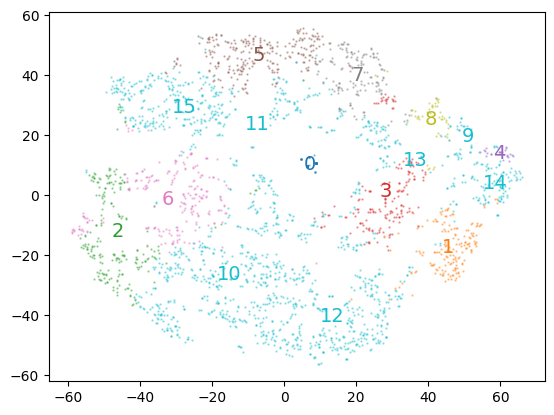

In [107]:
#Getting unique labels
# Plot the image without zooming in


u_labels = np.unique(label)
cps = []
#plotting the results:
# Define a color map for the scatter points
color_map = plt.cm.get_cmap('tab10')
n=np.arange(0,16)
for i in u_labels:
    x_coords = data_2d[label == i, 0]
    y_coords = data_2d[label == i, 1]
    plt.scatter(x_coords, y_coords, label=i, s=0.5, color=color_map(i),alpha = 0.4)
    center_point = np.mean(data_2d[label == i], axis=0)
    cps.append(center_point)
    #plt.scatter(center_point[0], center_point[1], color=color_map(i), s=14) 
    plt.annotate(str(i), (center_point[0], center_point[1]),fontsize=14, ha='center', va = 'center', color = color_map(i))
#     # Plotting the image on the center point
#     image = images[i]
#     img_height, img_width = image.shape[:2]
    
#     extent = [center_point[0]-img_width/2, center_point[0]+img_width/2,
#               center_point[1]-img_height/2, center_point[1]+img_height/2]
    
    
#     ax.imshow(image, extent=extent, alpha=0.7)
plt.show()

In [59]:
cps

[array([ 7.1477985, 10.381688 ], dtype=float32),
 array([ 45.57036 , -17.334732], dtype=float32),
 array([-46.208153, -12.097393], dtype=float32),
 array([28.045856,  1.451173], dtype=float32),
 array([59.565754, 14.021993], dtype=float32),
 array([-7.100253, 46.5976  ], dtype=float32),
 array([-32.314323 ,  -1.5266579], dtype=float32),
 array([20.370857, 39.83285 ], dtype=float32),
 array([40.554203, 25.278282], dtype=float32),
 array([51.078873, 19.672014], dtype=float32),
 array([-15.338022, -26.278395], dtype=float32),
 array([-7.462354, 23.571487], dtype=float32),
 array([ 13.286846, -40.377716], dtype=float32),
 array([36.50507 , 11.652095], dtype=float32),
 array([58.44355  ,  3.9612303], dtype=float32),
 array([-27.675346,  29.440813], dtype=float32)]

In [62]:
sorted_filenames

['recon_img\\reconstructed_1.png',
 'recon_img\\reconstructed_2.png',
 'recon_img\\reconstructed_3.png',
 'recon_img\\reconstructed_4.png',
 'recon_img\\reconstructed_5.png',
 'recon_img\\reconstructed_6.png',
 'recon_img\\reconstructed_7.png',
 'recon_img\\reconstructed_8.png',
 'recon_img\\reconstructed_9.png',
 'recon_img\\reconstructed_10.png',
 'recon_img\\reconstructed_11.png',
 'recon_img\\reconstructed_12.png',
 'recon_img\\reconstructed_13.png',
 'recon_img\\reconstructed_14.png',
 'recon_img\\reconstructed_15.png',
 'recon_img\\reconstructed_16.png']

In [64]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

1


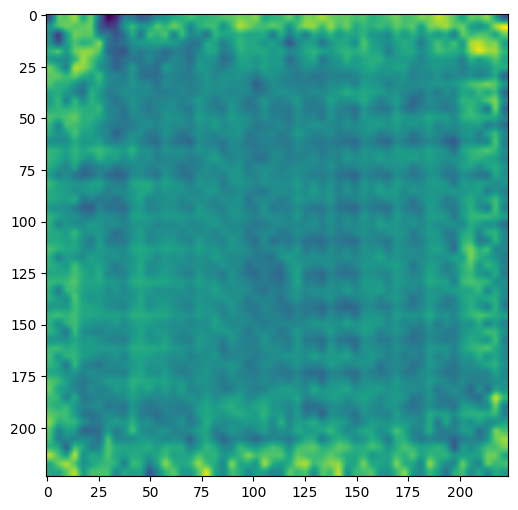

In [89]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figure size as needed
i=0
# Loop through the coordinates and images
for coord, img_path in zip(cps, sorted_filenames):
    i+=1
    if(i<2):
        print(i)
        img = plt.imread(img_path)
        plt.imshow(img)
        # imagebox = OffsetImage(img, zoom=0.2)
        # ab = AnnotationBbox(imagebox, coord, xycoords='axes fraction')
        # ax.add_artist(ab)
# plt.savefig("1.png", bbox_inches='tight')

In [ ]:
img = plt.imread(img_path)
plt.imshow(img)
plt.show()